In [3]:
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Стратификация

Цель данного ноутбука - реализовать стратифицированное разделение пользователей на группы,  
сравнить проведение тестов с использованием стратификации, постстратификации, без дополнений  
и узнать, какой выигрыш в снижении дисперсии и времени проведения теста может дать стратификация.


*Мотивация*  
Посмотрим на формулу расчета необходимого количества наблюдейний в выборках:  
$$n = \frac{(z_{1-\alpha} * z_{\beta}) * (\sigma^2_1 + \sigma^2_2)} {\varepsilon^2}$$  
$\alpha$ и $\beta$ у нас обычно зафиксированы, $\varepsilon$ мы менять не хотим,  
поэтому если мы хотим уменьшить необходимое число наблюдений в выборках, то приходится уменьшать диисперсию в выборках.  
В этом нам и должна помочь стратификация.

В чем заключается суть стратификации?  
Допустим у нас есть некоторые группы пользователей (страты), которые чем-то отличаются.  
Классический пример - операционные системы пользователей. Зачастую пользователи с ОС от Apple готовы тратить больше денег на различные услуги.  
Например, в игре Hearthstone цена внутреигровых покупок напрямую зависит от типа устройства пользователя,  
и люди, играющие с Iphone\Mac вынуждены платить больше.  
При стратифицированном разделении людей на группы мы набираем пользователей поровну из каждой страты а затем считаем среднее по стратам и усредняем его с учетов весов страт.  
за счет того, что поведение пользователей внутри страт отличается меньше, чем по всем пользователям, мы можем снизить дисперсию в выборках.

Давайте это реализуем

In [124]:
class MixedDistribution:
    '''
        Класс MixedDistribution хранит в себе комбинированную выборку из нескольких распределения.
        Функция get_casual_partition возвращает 2 случайные выборки размера group_size из смешанного распределения
        Функция get_strat_partition возвращает 2 стратифицированные выборки размера group_size из смешанного распределения
    '''
    def draw_distr_plot(self, ax=None):
        with sns.axes_style('darkgrid'):
            if ax is None:
                fig, ax = plt.subplots(figsize=(9, 6))
                plt.title('Плотность распределений')
                plt.xlabel('Значение')
                plt.ylabel('Плотность')
                need_legend = True
            sns.kdeplot(data=self.data, x='value', ax=ax, color='r' , linestyle='--', lw=2, label='kde итогового распределения')
            sns.kdeplot(data=self.data, x='value', ax=ax, hue='strat', lw=2, palette='deep', label='kde одного из исходных распределений')
            if need_legend:
                plt.legend()
                plt.show()

    def __init__(self, distrs, sizes, draw_plot=False):
        sample, strats = np.array([]), np.array([])
        for i, distr in enumerate(distrs):
            sample = np.concatenate((sample, distr.rvs(size=sizes[i])))
            strats = np.concatenate((strats, np.full(sizes[i], i)))
    
        self.data = pd.DataFrame({'value': sample, 'strat': strats})
        self.weights = np.array((self.data.groupby(by='strat').count() / self.data.groupby(by='strat').count().sum())['value'])
        self.strat_count = len(sizes)
        if draw_plot:
            self.draw_distr_plot()

    def get_casual_partition(self, group_size):
        return self.data.sample(group_size, replace=True), \
                self.data.sample(group_size, replace=True)

    def get_strat_partition(self, group_size):
        groups = [pd.DataFrame(), pd.DataFrame()]
        for i in range(2):
            for strat in range(self.strat_count):
                groups[i] = pd.concat((groups[i], \
                            self.data[self.data.strat == strat].sample(int(group_size * self.weights[strat]), replace=True)))
        return groups

Так как мы знаем размер выборки, которую мы возьмем, мы могли бы строго сохранить баланс наблюдений,  
которые семплируем из каждой страты с точностью до единицы.  
Однако в реальной жизни разделение на группы обычно происходит в онлайне, например, чтобы поддерживать возможность показывать пользователю разные версии страницы.  
Поэтому внутри каждой страты мы делим наблюдения на тест/контроль так же рандомно, имитируя онлайн алгоритм разделения.

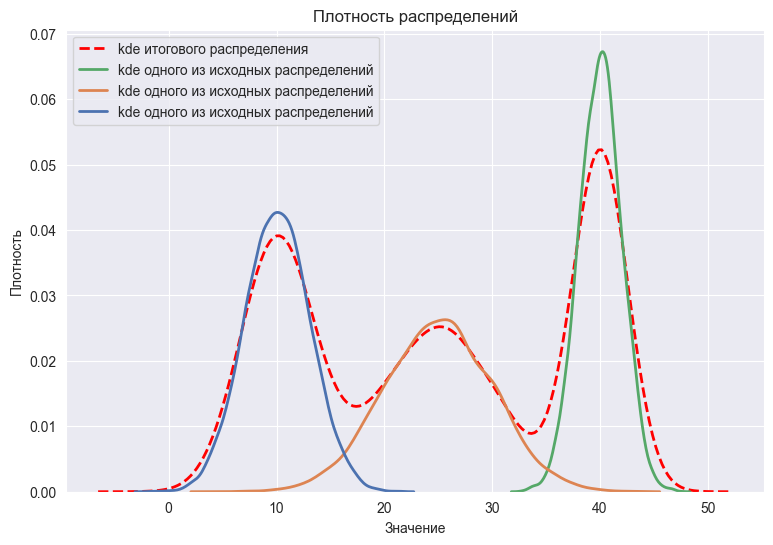

In [48]:
distrs = [sps.norm(10, 3), sps.norm(25, 5), sps.norm(40, 2)]
size = 10 ** 4
sizes = [size for i in range(3)]
mixed = MixedDistribution(distrs, sizes, draw_plot=True)

В графике явно видны выделяющиеся страты в итоговом распределении

Теперь реализуем функции подсчета обычного среднего и стратифицированного

In [6]:
def calc_casual_mean(samples):
    means = []
    for sample in samples:
        means.append(sample.value.mean())
    return means[0] if len(means) == 1 else means

In [7]:
def calc_strat_mean(samples, mixed_d: MixedDistribution):
    means = []
    for sample in samples:
        cur_mean = np.array(sample.groupby(by='strat').mean().value) * mixed_d.weights
        means.append(cur_mean.sum())
    return means[0] if len(means) == 1 else means

Теперь посмотрим на распределение разницы средних при использовании стратификации, постстратификации и без стратификации

In [8]:
def get_mean_diff(mixed_d: MixedDistribution, sample_size=1000, n_iter=10000):
    mean_diff = {'strat': [], 'nostrat': [], 'poststrat': []}
    for i in tqdm(range(n_iter)):
        X1, X2 = mixed_d.get_casual_partition(sample_size)

        nostrat_means = calc_casual_mean([X1, X2])
        mean_diff['nostrat'].append(nostrat_means[0] - nostrat_means[1])

        poststrat_means = calc_strat_mean([X1, X2], mixed_d)
        mean_diff['poststrat'].append(poststrat_means[0] - poststrat_means[1])

        X1_strat, X2_strat = mixed_d.get_strat_partition(sample_size)
        strat_means = calc_strat_mean([X1_strat, X2_strat], mixed_d)
        mean_diff['strat'].append(strat_means[0] - strat_means[1])

    return mean_diff

In [9]:
def draw_mean_diff_plot(mixed_d: MixedDistribution, sample_size=1000, n_iter=10000, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    mean_diff = get_mean_diff(mixed_d, sample_size, n_iter)

    with sns.axes_style('darkgrid'):
        ax.set_title('Размер выборок {}'.format(sample_size))
        sns.kdeplot(x=mean_diff['nostrat'], ax=ax, lw=2, label='Без стратификации')
        sns.kdeplot(x=mean_diff['poststrat'], ax=ax, lw=2, label='Постстратификация')
        sns.kdeplot(x=mean_diff['strat'], ax=ax, lw=2, label='Стратификация')
        ax.set_ylabel('')
    

In [10]:
def draw_mean_diff_plots(mixed_d: MixedDistribution, sizes=[100, 500, 1000], n_iter=10000, nrows=1, ncols=3, figsize=(12, 6)):
    with sns.axes_style('darkgrid'):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        plt.suptitle('Распределение разности средних для разных размеров выборок, \n количество итераций: {}'.format(n_iter))
        for size, ax in zip(sizes, axes.flatten()):
            draw_mean_diff_plot(mixed_d, sample_size=size, n_iter=n_iter, ax=ax)
        handles, labels = axes.flatten()[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.supylabel('Плотность')
        fig.supxlabel('Значение')
        fig.show()

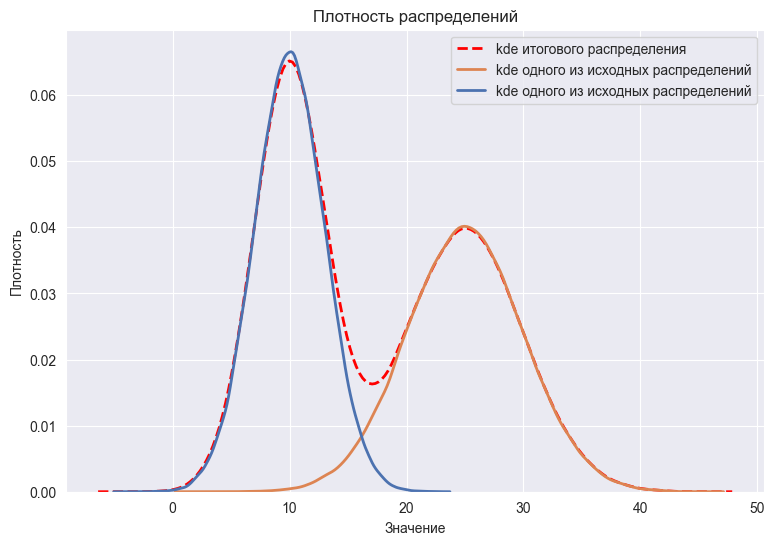

In [179]:
distrs = [sps.norm(10, 3), sps.norm(25, 5)]
size = 10 ** 5
sizes = [size for i in range(len(distrs))]
mixed_2_strat = MixedDistribution(distrs, sizes, draw_plot=True)

Это наше распределение с двумя явно выделяющимися стратами.  
Давайте посмотрим, как использование стратификации влияет на распределение разности средних выборок из данного распределения.

100%|██████████| 5000/5000 [01:20<00:00, 62.45it/s]


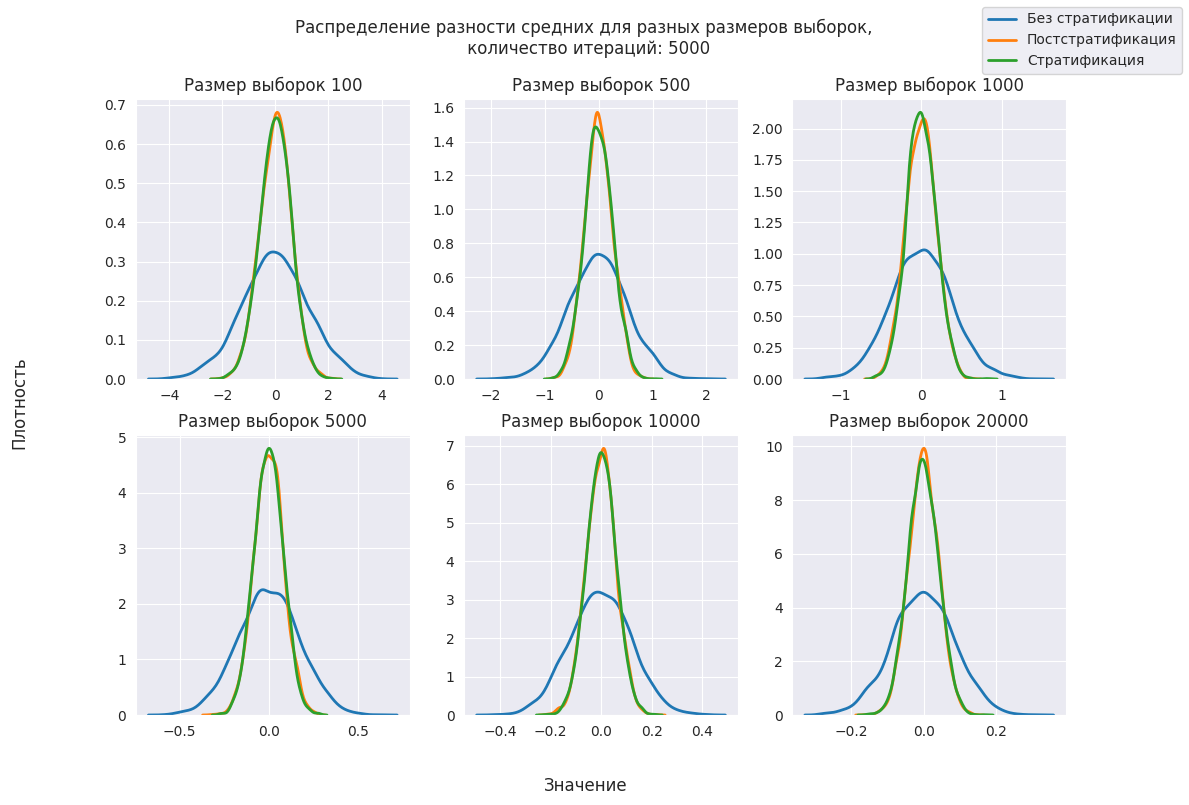

In [181]:
sizes = [100, 500, 1000, 5000, 10000, 20000]
draw_mean_diff_plots(mixed_2_strat, sizes=sizes, n_iter=5000, nrows=2, ncols=3, figsize=(12, 8))

Как можно видеть, использование стратификации и постстратификации значительно уменьшает дисперсию разницы средних.

Я сразу писал код для построения нескольких графиков, так как ожидал, что с ростом размеры выборки эффект от стратификации будет снижаться, в виду того, что перекосы по стратам будут меньше.  
Однако можно видеть, что форма распределений практически не меняется, с ростом размера выборки только снижается абсолютное значение дисперсии.  
Так как при стратификации и постстратификации результаты получаются практически однаковые, можно сделать вывод, что влияение оказывает не механизм сплитования, а использования стратифицированного среднего.  
Чтобы понять, почему графики распределений получились такими посмотрим на формулы дисперсии средних в различных вариациях.

![Дисперсия средних](../pictures/strat_var.png)

Картинка взята [отсюда](https://habr.com/ru/companies/X5Tech/articles/596279/), там же можно посмотреть вывод этих формул.  
По формулам мы видим, что дисперсия снижается линейно в зависимости от размера выборок, причем в случае постстратификации в дисперсии  
есть дополнительное слагаемое относительно стратификации, однако оно имеет множитель $\frac{1}{n^2}$, поэтому не оказывает большого влияния.  
При случайной разбиении и обычном среднем дополнительно слагаемое уже имеет коэффициент $\frac{1}{n}$, поэтому оказывает существенное влияение.  
В нашем случае $w_{1, 2}=0.5$, поэтому можно вынести их за сумму, $\sigma^2_1 + \sigma^2_2 = 25 + 9 = 34$, $(\mu_1 - \mu)^2 + (\mu_2 - \mu)^2 = 112.5$,  
поэтому использование стратифицированного среднего оказывает большое влияние на дисперсию вне зависимости от размера выборок.

Давайте подробнее посмотрим на влияние стратификации в зависимости от количества страт и от разницы матожиданий в стратах.

In [298]:
def draw_mean_distr_by_strats_num(strats_pack, size=10 ** 3, n_iter=10 ** 4, figsize=(12, 8), total_size=10 ** 5):
    with sns.axes_style('darkgrid'):
        fig, axes = plt.subplots(2, len(strats_pack), figsize=figsize)
        plt.suptitle('Распределение разности средних для разного количества страт, \n количество итераций: {}, размер выборок: {}'.format(n_iter, size))

        for row in range(len(strats_pack)):
            mixed_d = MixedDistribution(strats_pack[row], [total_size for i in range(len(strats_pack[row]))], draw_plot=False)
            mixed_d.draw_distr_plot(ax=axes[0, row])
            axes[0, row].set_xlabel('')
            axes[0, row].set_ylabel('')
            axes[0, row].set_title(f'Распределение из {len(strats_pack[row])} страт', fontsize=12)
            draw_mean_diff_plot(mixed_d, sample_size=size, n_iter=n_iter, ax=axes[1, row])
            axes[1, row].set_title(f'Распределение разности средних\nиз распределения из {len(strats_pack[row])} страт', fontsize=12)
        
        handles, labels = axes[0, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left', fontsize='small')
        handles, labels = axes[1, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower left', fontsize='small')
        fig.supylabel('Плотность')
        fig.supxlabel('Значение')
        fig.show()

100%|██████████| 10000/10000 [02:19<00:00, 71.56it/s]


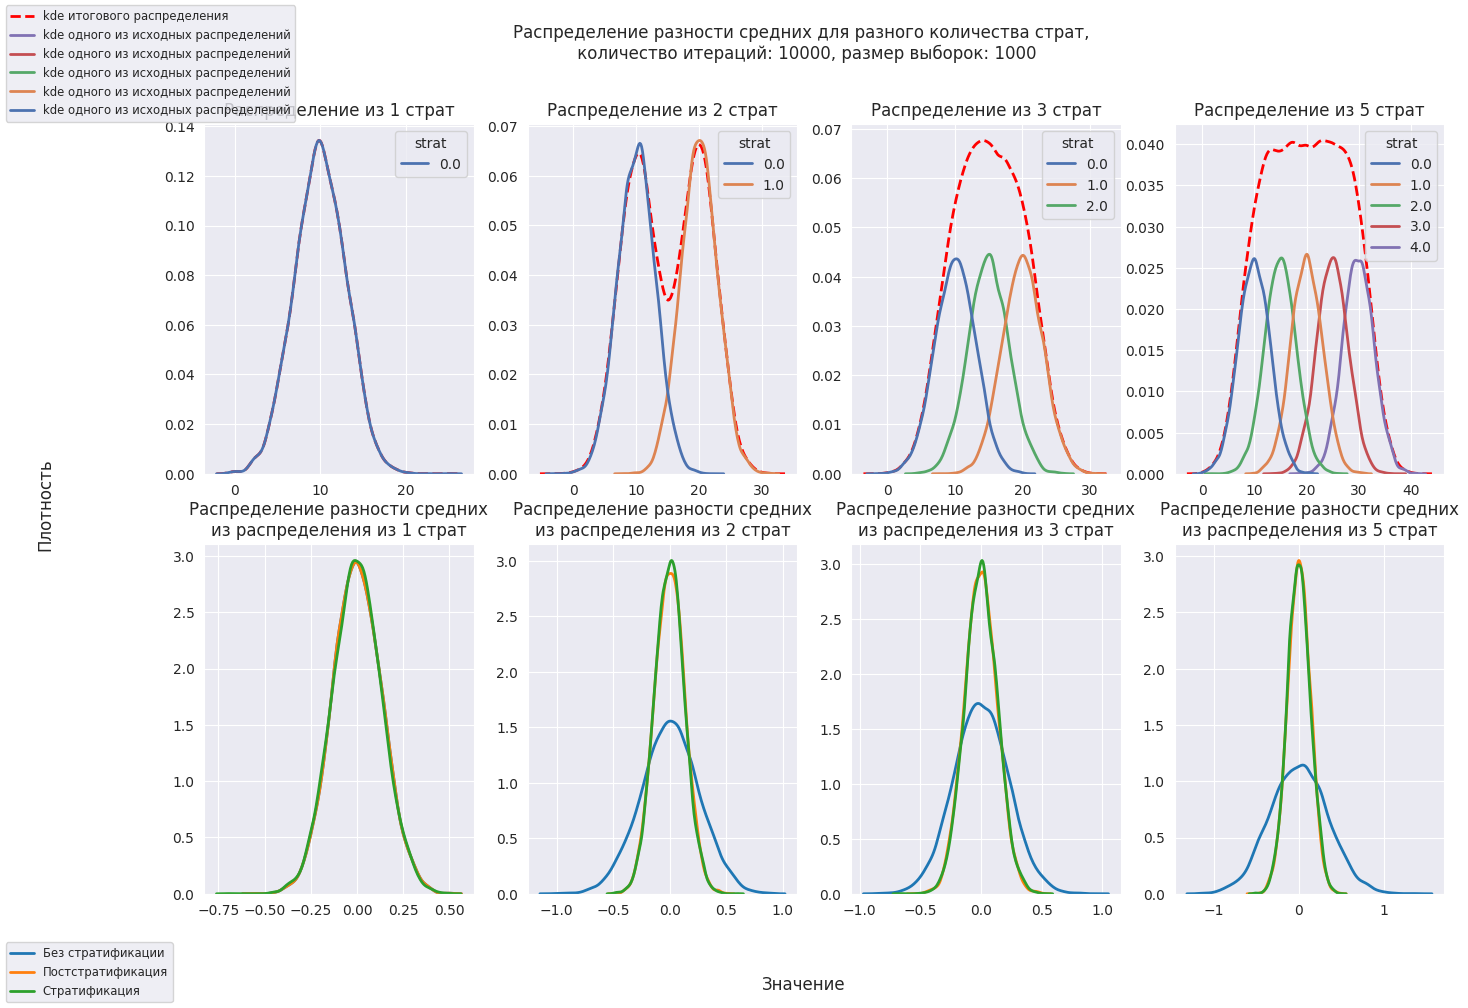

In [299]:
distrs = [sps.norm(10, 3), sps.norm(20, 3), sps.norm(15, 3), sps.norm(25, 3)]
strats_pack = [distrs[:i] for i in range(1, len(distrs) + 1)]
strats_pack[-1].append(sps.norm(30, 3))
draw_mean_distr_by_strats_num(strats_pack, n_iter=10000, total_size=10000, figsize=(16, 10))

Можно видеть, что при переходе к трем стратам эффект от стратификации даже снизился.  
Это связано с тем, что третья страта была вставлена между первыми двумя, таким образом она не увеличила  
обычную дисперсию средних, а веса страт только снизились.  
Помимо этого случая видна тенденция, что при увеличении количества страт обычная дисперсия средних становится  
все больше относительно стратифицированной.

In [295]:
def draw_mean_distr_by_strat_shift(strats_pack, shifts, size=10 ** 3, n_iter=10 ** 4, figsize=(12, 8), total_size=10 ** 5):
    with sns.axes_style('darkgrid'):
        fig, axes = plt.subplots(2, len(strats_pack), figsize=figsize)
        plt.suptitle('Распределение разности средних для разного количества страт, \n количество итераций: {}, размер выборок: {}'.format(n_iter, size))

        for row in range(len(strats_pack)):
            mixed_d = MixedDistribution(strats_pack[row], [total_size for i in range(len(strats_pack[row]))], draw_plot=False)
            mixed_d.draw_distr_plot(ax=axes[0, row])
            axes[0, row].set_xlabel('')
            axes[0, row].set_ylabel('')
            axes[0, row].set_title(f'Смешанное распределение,\nсдвиг второй страты {shifts[row]}', fontsize=12)
            draw_mean_diff_plot(mixed_d, sample_size=size, n_iter=n_iter, ax=axes[1, row])
            axes[1, row].set_title(f'Распределение разности средних\nиз распределения выше', fontsize=12)
        
        handles, labels = axes[0, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left', fontsize='small')
        handles, labels = axes[1, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower left', fontsize='small')
        fig.supylabel('Плотность')
        fig.supxlabel('Значение')
        fig.show()

100%|██████████| 10000/10000 [01:19<00:00, 125.14it/s]


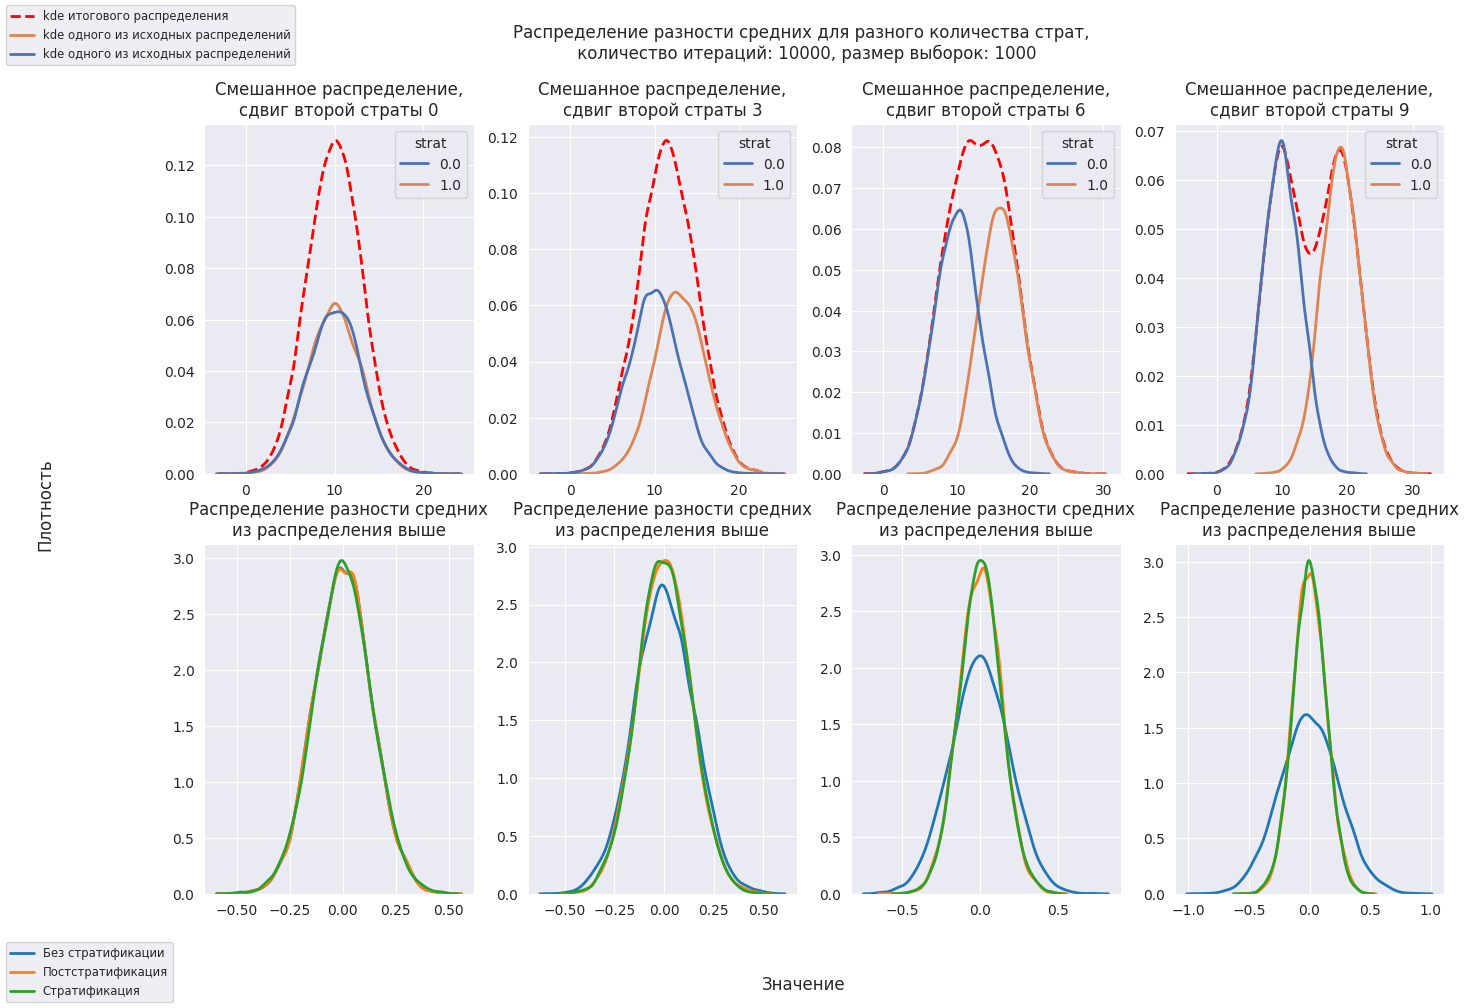

In [296]:
mean, sigma, shift, iter = 10, 3, 3, 4
first_strat = sps.norm(mean, sigma)
strats_pack = [[first_strat, sps.norm(mean + shift * i, sigma)] for i in range(iter)]
shifts = [shift * i for i in range(iter)]
draw_mean_distr_by_strat_shift(strats_pack, shifts, n_iter=10000, total_size=10000, figsize=(16, 10))

Здесь аналогично видим, что чем больше разность средних, тем больше станосится дисперсия разности средних в случае, когда мы не используем стратификацию.  
При применении стратификации форма распределения средних не меняется.

Давайте теперь напишем функцию теста с использованием стратификации и посмотрим, как она влияет на тест.

In [11]:
def get_mean(mixed_d: MixedDistribution, sample):
    return sample.value.mean()

def get_strat_mean(mixed_d: MixedDistribution, sample):
    return np.sum(np.array(sample.groupby(by='strat').mean().value) * mixed_d.weights)

def get_var(mixed_d: MixedDistribution, sample):
    return sample.value.var() / len(sample)

def get_strat_var(mixed_d: MixedDistribution, sample):
    return np.sum(np.array(sample.groupby(by='strat').var().value) * mixed_d.weights) / len(sample)

def get_poststrat_var(mixed_d: MixedDistribution, sample):
    return get_strat_var(mixed_d, sample) + \
        np.sum(np.array(sample.groupby(by='strat').var().value) * (1 - mixed_d.weights)) / len(sample) ** 2

In [12]:
mean_f = {'strat': get_strat_mean, 'nostrat': get_mean, 'poststrat': get_mean}
var_f = {'strat': get_strat_var, 'nostrat': get_var, 'poststrat': get_poststrat_var}

def ttest(mixed_d: MixedDistribution, samples, type_: 'strat' or 'poststrat' or 'nostrat', alpha = 0.05):
    mean = [mean_f[type_](mixed_d, sample) for sample in samples]
    var = [var_f[type_](mixed_d, sample) for sample in samples]
    t_stat = (mean[0] - mean[1]) / np.sqrt(var[0] + var[1])
    pvalue = 2 * sps.norm.cdf(x=-np.abs(t_stat))

    return int(pvalue < alpha)

In [98]:
def add_shift(sample, shift):
    sample.value += sps.norm(shift, 1).rvs(len(sample))

In [117]:
def draw_reject_plot(calc_alpha, left_alpha, right_alpha, t_alpha, ax=None):
    ax.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
    ax.vlines(t_alpha, -1, 1, color='r', lw=5, linestyle='--', alpha=0.6, label=r'Целевой % отвержения')
    ax.fill_between([left_alpha, right_alpha], [0.15] * 2, [-0.15] * 2, color='g', alpha=0.6, label=r'Доверительный интервал для % отвержений')
    ax.scatter(calc_alpha, 0, s=300, marker='*', color='r', label=r'Наблюдаемый % отвержений')
    ax.set_xlim((min(t_alpha, left_alpha) - 0.005, max(t_alpha, right_alpha) + 0.005))
    ax.set_ylim((-0.5, 0.5))
    ax.set_yticks([])


In [147]:
def draw_rejects_plot(calc_val, left, right, teor, labels, doplabel=''):
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(9, 9))
        gs = gridspec.GridSpec(3, 1)
        eps = 0.01
        min_x, max_x = min(calc_val + left + right + [teor]) - eps, max(calc_val + left + right + [teor]) + eps
        for i in range(3):
            ax = plt.subplot(gs[i])
            draw_reject_plot(calc_val[i], left[i], right[i], teor, ax=ax)
            ax.set_ylabel(labels[i])
            ax.set_xlim(min_x, max_x)

        handles, labels = plt.subplot(gs[0]).get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower right', fontsize='small')
        fig.supxlabel('% отвержений')
        fig.suptitle('% Отвержений для различных методов тестирования\n' + doplabel)
        plt.subplots_adjust(top=0.92)

In [132]:
def AB_test(mixed_d, total_size=10 ** 6, sample_size=10 ** 3, n_iter=10 ** 3, alpha=0.05, shift=0, target=0.05):
    rejects = {'nostrat': 0, 'poststrat': 0, 'strat': 0}
    for _ in tqdm(range(n_iter)):
        for type_ in rejects.keys():
            if type_ != 'strat':
                rand_samples = mixed_d.get_casual_partition(sample_size)
            else:
                rand_samples = mixed_d.get_strat_partition(sample_size)
            add_shift(rand_samples[1], shift)
            rejects[type_] += ttest(mixed_d, rand_samples, type_=type_, alpha=alpha)
    
    rejects_b = [[], [], []]
    for type_ in rejects.keys():
        left_b, right_b = proportion_confint(rejects[type_], n_iter, method='wilson')
        rejects_b[0].append(rejects[type_] / n_iter)
        rejects_b[1].append(left_b)
        rejects_b[2].append(right_b)

    doplabel = f'sample_size: {sample_size}, n_iter: {n_iter}, shift: {shift} ' + ('(AB test)' if shift else '(AA test)')
    draw_rejects_plot(rejects_b[0], rejects_b[1], rejects_b[2], target, labels=list(rejects.keys()), doplabel=doplabel)

In [141]:
x = [1, 2, 3]
y = [5, 7, 8]
z = 6
np.max(x + y)

8

Функции написаны, проведем АА и АБ тесты, используя следующее распределение:

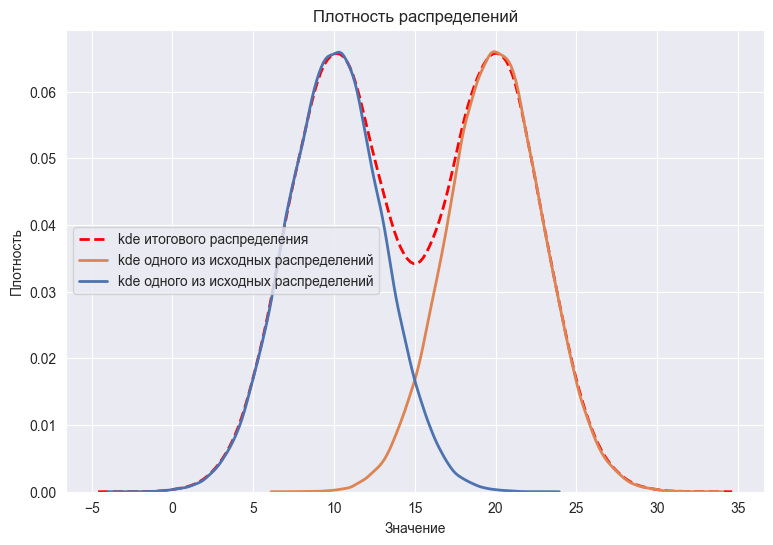

In [125]:
strats = [sps.norm(10, 3), sps.norm(20, 3)]
mixed_2_strat = MixedDistribution(strats, sizes=[10 ** 5 for i in range(len(strats))], draw_plot=True)

100%|██████████| 10000/10000 [04:04<00:00, 40.88it/s]


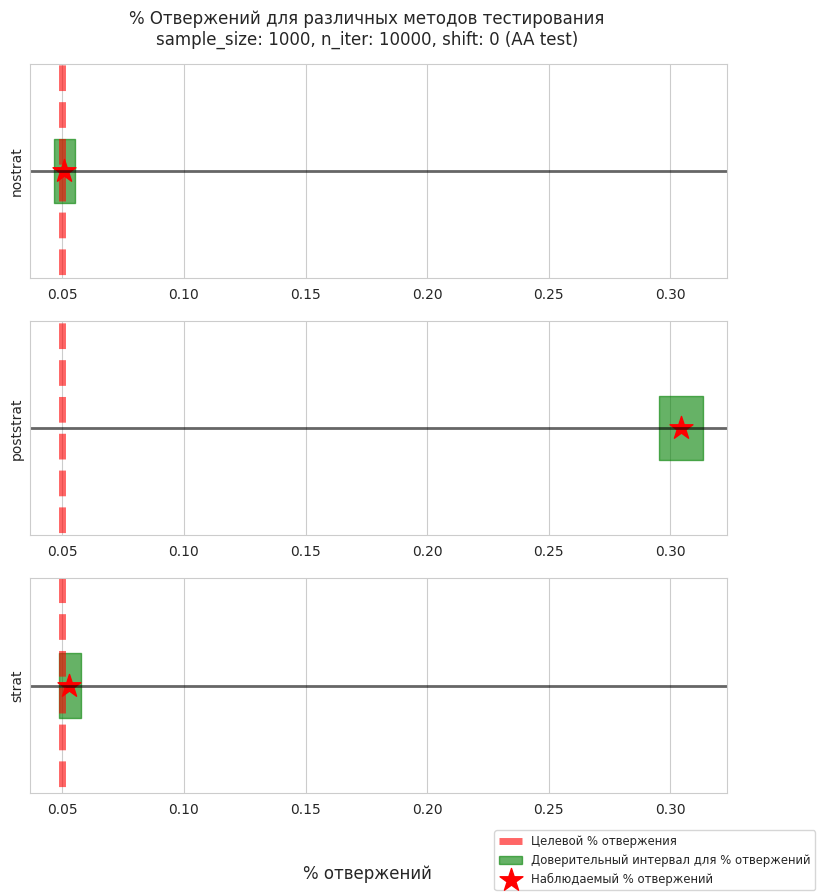

In [149]:
AB_test(mixed_2_strat, n_iter=10 ** 4, sample_size=10 ** 3, shift=0)

Видим, что при использовании постстратификации уровень значимости сильно отклоняется от заданного.

100%|██████████| 10000/10000 [03:59<00:00, 41.83it/s]


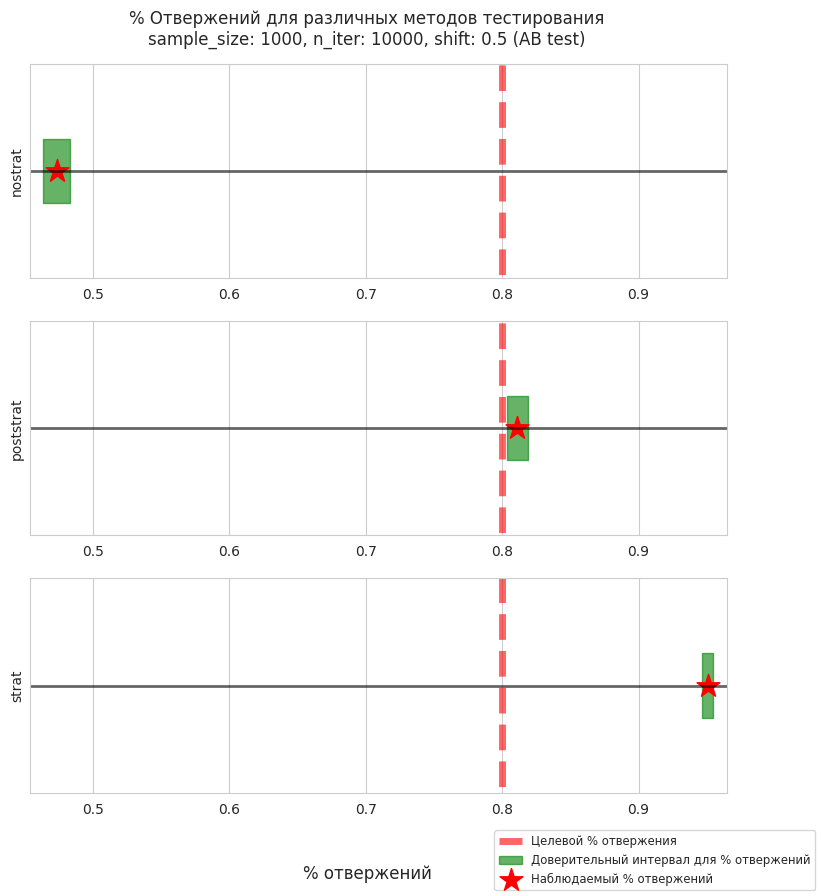

In [150]:
AB_test(mixed_d, n_iter=10 ** 4, sample_size=10 ** 3, shift=0.5, target=0.8)

При наличии двух страт с сильно отличающимся средним стратификация помогла нам увеличить мощность теста в 2 раза!  

Давайте теперь посмотрим, что происходит, когда среднее в стратах отличается не так сильно

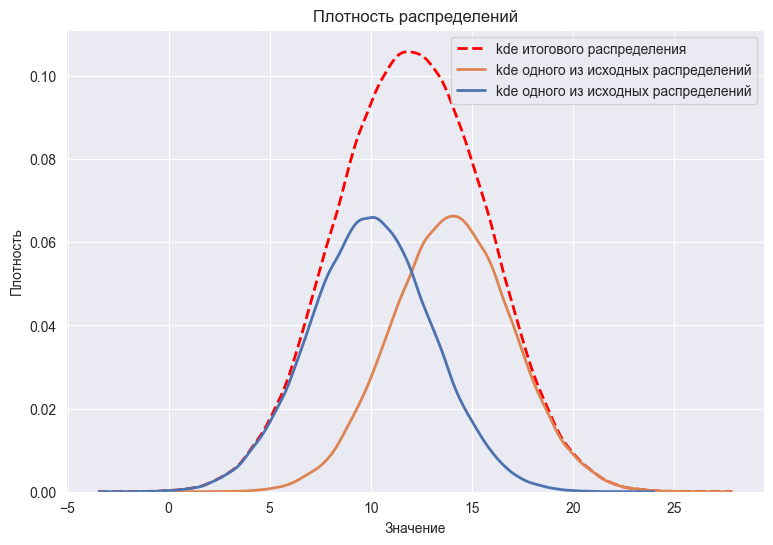

In [151]:
strats = [sps.norm(10, 3), sps.norm(14, 3)]
mixed_2_strat_low_shift = MixedDistribution(strats, sizes=[10 ** 5 for i in range(len(strats))], draw_plot=True)

100%|██████████| 10000/10000 [03:31<00:00, 47.21it/s]


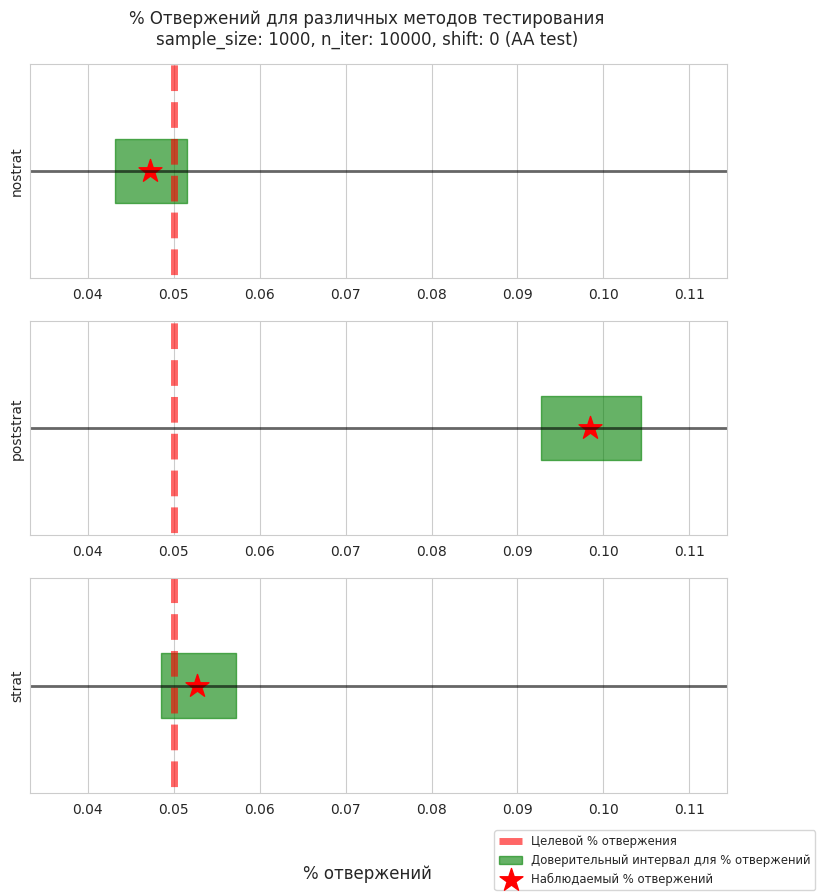

In [152]:
AB_test(mixed_2_strat_low_shift, n_iter=10 ** 4, sample_size=10 ** 3, shift=0)

С уровнем значимости ситуация аналогична

100%|██████████| 10000/10000 [03:25<00:00, 48.62it/s]


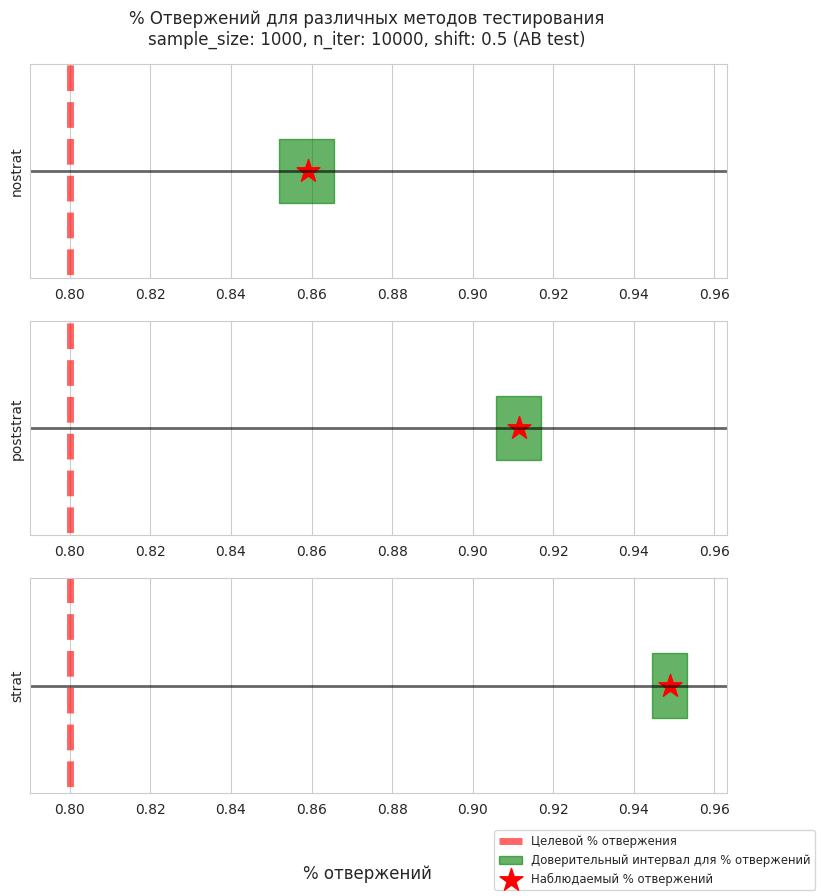

In [153]:
AB_test(mixed_2_strat_low_shift, n_iter=10 ** 4, sample_size=10 ** 3, shift=0.5, target=0.8)

При более близких стратах стратификация меньше влияет на мощность, но положительный эффект все так же есть.

Теперь давайте проверим, что в случае отсутствия страт эффекта нет

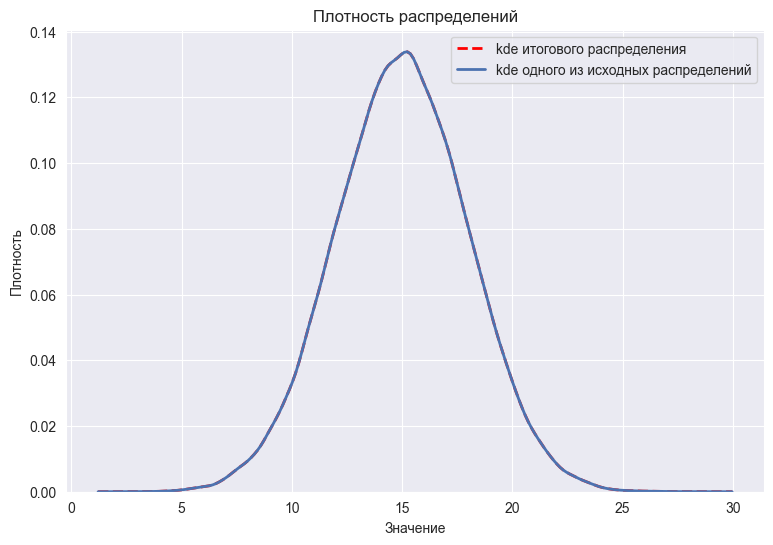

In [154]:
strats = [sps.norm(15, 3)]
mixed_no_strats = MixedDistribution(strats, sizes=[10 ** 5 for i in range(len(strats))], draw_plot=True)

100%|██████████| 10000/10000 [02:30<00:00, 66.44it/s]


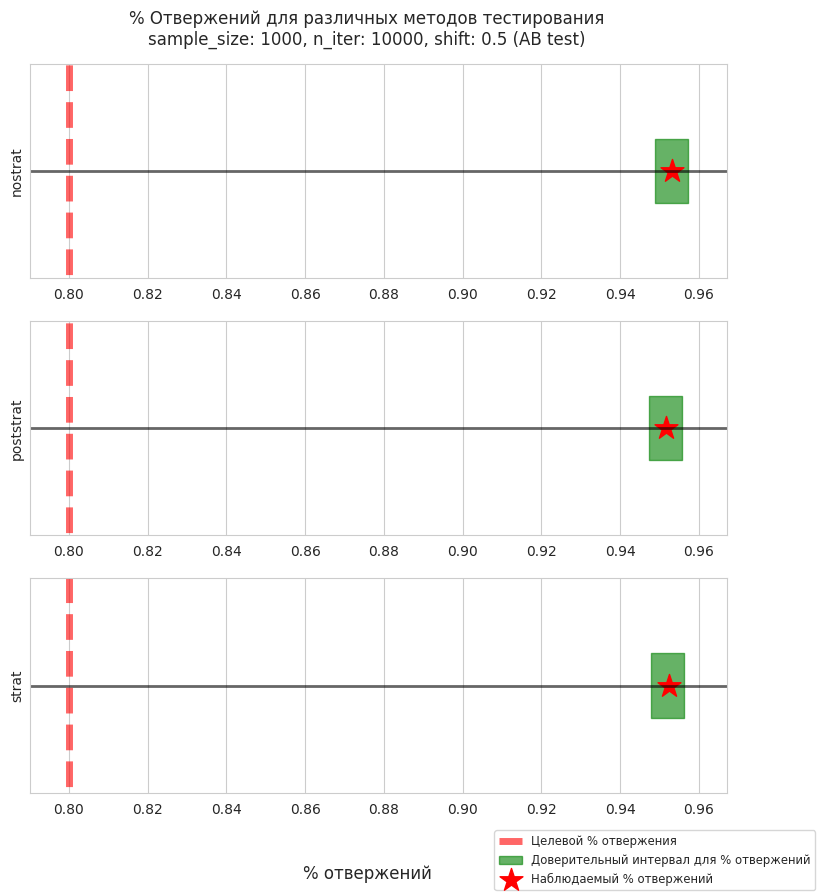

In [155]:
AB_test(mixed_no_strats, n_iter=10 ** 4, sample_size=10 ** 3, shift=0.5, target=0.8)

Действительно, в данном случае эффект от стратификации отсутствует

Теперь сделаем "экстремальное" распределение с восемью стратами и посмотрим что будет

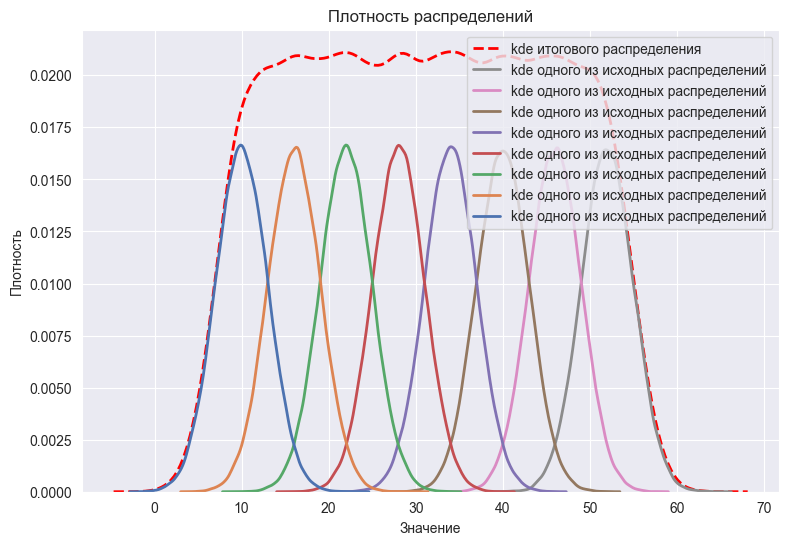

In [160]:
strats = [sps.norm(mean, 3) for mean in range(10, 53, 6)]
mixed_many_strats = MixedDistribution(strats, sizes=[10 ** 5 for i in range(len(strats))], draw_plot=True)

100%|██████████| 10000/10000 [09:09<00:00, 18.20it/s]


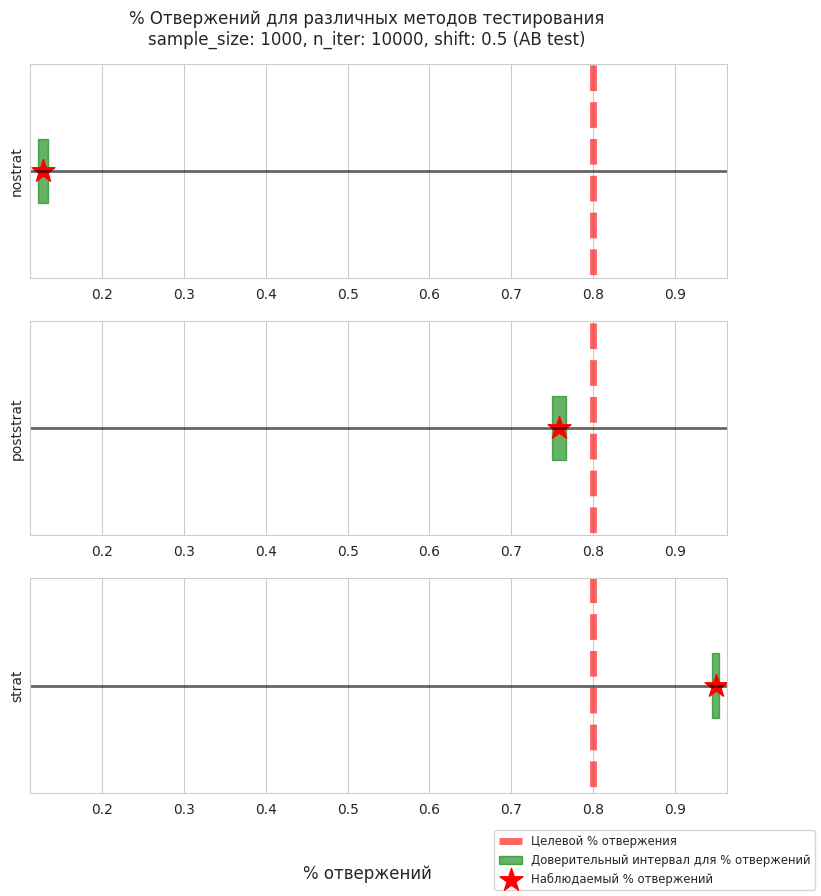

In [161]:
AB_test(mixed_many_strats, n_iter=10 ** 4, sample_size=10 ** 3, shift=0.5, target=0.8)

При большом количестве страт тест без использования стратификации практически перестает отвергать нулевую гипотезу,  
что говорит нам о необходимости использования стратификации в данном случае

Наконец, разнесем страты очень сильно и проведем тесты.

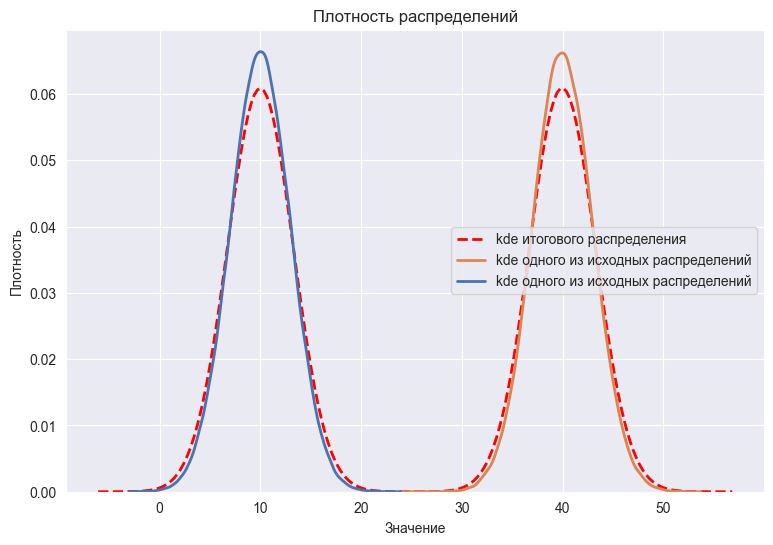

In [162]:
strats = [sps.norm(10, 3), sps.norm(40, 3)]
mixed_2_strats_big_shift = MixedDistribution(strats, sizes=[10 ** 5 for i in range(len(strats))], draw_plot=True)

100%|██████████| 10000/10000 [03:30<00:00, 47.57it/s]


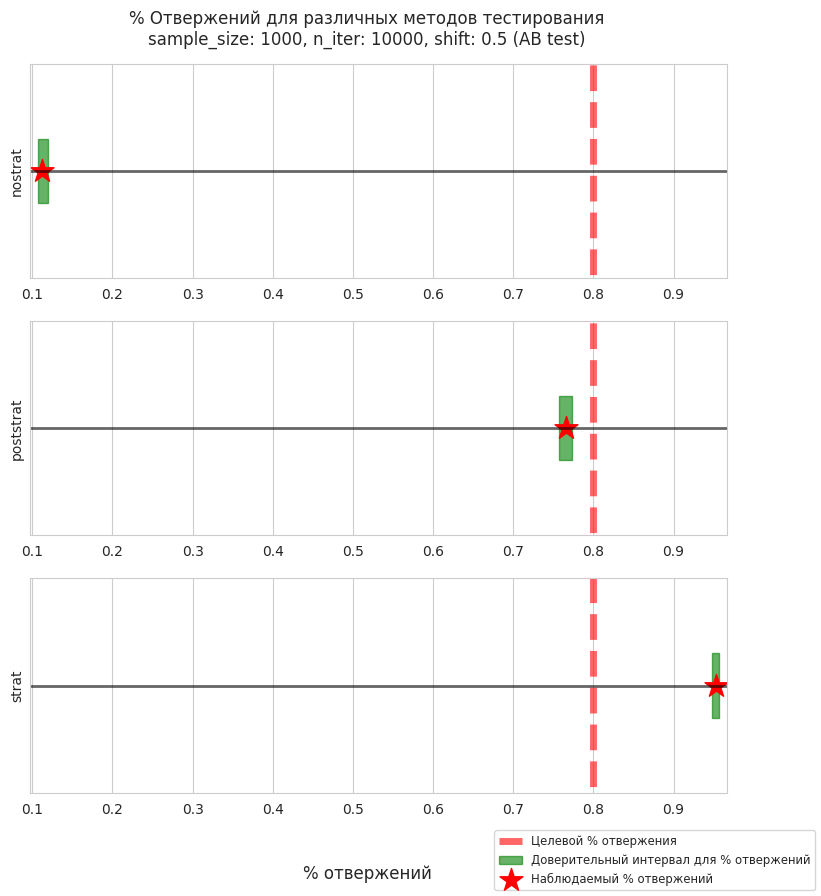

In [163]:
AB_test(mixed_2_strats_big_shift, n_iter=10 ** 4, sample_size=10 ** 3, shift=0.5, target=0.8)

При очень сильно отличающихся стратах обычный тест Стьюдента имеет околонулевую мощность -> по сути бесполезен

*Итоговые выводы:*  
1) Стратификация - мощный инструмент, позволяющий увеличить мощность теста при наличии различающихся страт в исходном распределении.  
2) Если же страт много или они сильно отличаются, то использование стратификации является необходимостью, так как обычный тест будет отвергать нулевую гипотезу  
крайне редко даже при наличии эффекта.  
3) Постстратификация так же позволяет увеличить мощность теста, однако ее эффект может быть заметно ниже, чем при стратифицированном семплировании,  
помимо этого при использовании постстратификации повышается вероятность ошибки первого рода, по крайней мере в некоторых случая.  
4) Если же мы хотим держать мощность теста на заданном уровне, то при использовании стратификации мы можем набирать группы меньшего размера  
при сохранении мощности (следствие из формулы MDE). Это позволяет проводить тесты быстрее -> за заданный промежуток времени можно провести больше тестов  
и получить больше профита.

# Бонус

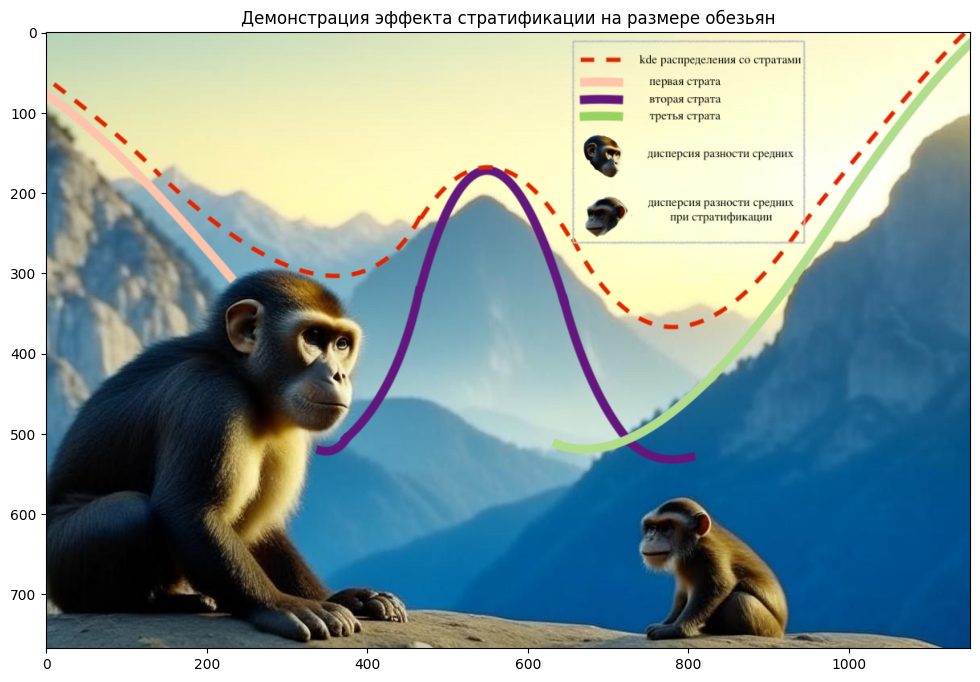

In [166]:
image = plt.imread('../monkeys/monkeys_strat.jpg')
plt.figure(figsize=(12, 8))
plt.title('Демонстрация эффекта стратификации на размере обезьян')
plt.imshow(image)
plt.show()